In [1]:
import random
import pandas as pd
import numpy as np
import os
import glob
import tensorflow as tf
from tensorflow.data import Dataset
import tensorflow.keras as keras
from tqdm.auto import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor 
datapath='./drive/MyDrive/project'
class CFG:
    seed = 42
    VERBOSE = 1
    random_state = 42
    N_FOLDS = 28
    EPOCHS = 400
    WINDOW_SIZE = 24
    BATCH_SIZE = 16
    factor = 0.5
    patience_1 = 5
    patience_2 = 15
    learning_rate = 1e-3
    weight_decay = 1e-3
    dropout_rate = 0.2
    features_num = 15

<h2>데이터 fetch, Min-Max scaling, concat </h2>

In [75]:
def impute_data(df,col_idx,sta_value,beq=True,mode='mean'):
    if beq:
        index_lists = df[df.iloc[:,col_idx] >= sta_value].index
    else:
        index_lists = df[df.iloc[:,col_idx] < sta_value].index
        
    index_lists = divide_list(index_lists)
    for index_list in index_lists:
        # 이상값 기준으로 위 아래 값 포함하여 평균값으로 바꾸어준다.
        if mode == 'mean':
            df.iloc[range(index_list[0]-1,index_list[-1]+2),col_idx] = np.mean(df.iloc[index_list[0]-2,col_idx]+df.iloc[index_list[-1]+2,col_idx])
        # 이상값을 최대, 최소값으로 바꾼다.
        elif mode == 'const':
            df.iloc[index_list,col_idx] = sta_value
        # 이상값을 바로 전 값에서 가져온다.
        elif mode == 'impute':
            for idx in index_list:
                df.iloc[idx,col_idx] = df.iloc[idx-1,col_idx]
    return df

# 24시간기준 누적합 feature 생성함수
def cumsum_feature(df,col_idx):
    for idx_list in np.array(df.index).reshape(-1,CFG.WINDOW_SIZE):
        cum = 0
        for idx in idx_list:
            cum += df.iloc[idx,col_idx-1]
            df.iloc[idx,col_idx] = cum
    return df

def feature_processing(df):
    idx_observe = [1,2,3] # 관측값들 (ec관측값 제외)
    idx_per_hour = [5,7,9,11] # 시간당 분무량, 광량 등...
    
    impute_data(df,1,SCOPE.AVG_TEMP_PER_HOUR[0],False)
    impute_data(df,1,SCOPE.AVG_TEMP_PER_HOUR[1],mode='const')
    impute_data(df,2,4,False,mode='mean')
    impute_data(df,3,200,False,mode='mean')
    for idx in idx_per_hour:
        impute_data(df,idx,0,False,mode='impute')
        df = cumsum_feature(df,idx+1)
    for idx in df.index:
        df.iloc[idx,13] = df.iloc[idx,7]+df.iloc[idx,9]+df.iloc[idx,11]
    df = cumsum_feature(df,14)
    return df

class SCOPE:
    AVG_TEMP_PER_HOUR = (4.0,40.0) # 시간당 내부 평균온도
    AVG_HUMI_PER_HOUR = (0.0,100.0) # 시간당 내부 평균습도
    AVG_CO2_PER_HOUR = (0.0,1200.0) # 시간당 내부 평균 co2 농도
    AVG_EC_PER_HOUR = (0.0,8.0) # 시간당 평균 EC
    WATER_PER_HOUR = (0.0,3000.0) # 시간당 분무량
    WATER_PER_DAY = (0.0,72000.0) # 일간 누적 분무량
    LIGHT_PER_HOUR = (0.0,120000.0) # 시간당 광량 (백색,적색,청색,총 모두다 동일)
    LIGHT_PER_DAY = (0.0, 2880000.0) # 일간 누적 광량 (백색,적색,청색,총 모두다 동일)

def divide_list(lists):
    result = []
    f = lambda arr, x: arr[:-1] + [arr[-1] + [x]] if arr and arr[-1][-1]+1 == x else arr + [[x]]
    for i in lists:
        result = f(result, i)
    return result

all_input_list = sorted(glob.glob(datapath+'/train_input/*.csv'))
all_target_list = sorted(glob.glob(datapath+'/train_target/*.csv'))

df_train_input = pd.concat(map(pd.read_csv, all_input_list)).drop(columns='obs_time').reset_index(drop=True)
df_train_target = pd.concat(map(pd.read_csv, all_target_list)).drop(columns='DAT').reset_index(drop=True)

df_train_input = feature_processing(df_train_input)

In [76]:
df_train_input.describe()

,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
count,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000
mean,13.500000,26.032475,63.947718,499.029870,1.507566,523.754489,6368.827806,6323.887039,72985.157131,1572.418470,18206.359016,1243.074695,14149.703387,9139.380204,105341.219534
std,8.077962,3.943901,11.645382,120.468588,1.042010,544.201487,6906.660634,8120.302985,86081.478567,2936.280442,34385.315268,2470.257771,27744.564605,9087.018819,97437.426978
min,0.000000,13.238833,15.348148,314.883333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.750000,23.975000,57.497500,420.312500,0.929581,0.000000,1234.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7280.962850
50%,13.500000,26.291714,62.121801,474.050424,1.308517,252.000000,3362.750000,0.000000,23205.750000,0.000000,0.000000,0.000000,0.000000,9242.350000,92337.840000
75%,20.250000,28.110000,73.158333,551.216667,2.291322,769.000000,9993.267500,18236.625400,145422.700000,1495.939200,17529.296400,1306.461000,18610.020000,18255.190000,177610.067800
max,27.000000,40.000000,93.350002,1714.850000,5.462324,3144.130000,42855.230000,18564.600000,292014.969800,9928.800000,200561.760000,9399.000000,190016.450000,37892.400000,559488.881000


In [78]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
def Scaling(data,scaler='MinMax'):
  for i in range(28*28):
    for j in [6,8,10,12,14]:
      if data.iloc[(i+1)*24-1,j] != 0 :
        data.iloc[i*24:(i+1)*24,j]=data.iloc[i*24:(i+1)*24,j]/data.iloc[(i+1)*24-1,j]
  if scaler=='StandardScaler':
    return StandardScaler().fit_transform(data)
  return MinMaxScaler().fit_transform(data)

columns=df_train_input.columns
std_inputs = pd.DataFrame(Scaling(df_train_input,'StandardScaler'),columns=columns)
mmx_inputs = pd.DataFrame(Scaling(df_train_input),columns=columns)

In [107]:
def Convert_for_tradition(data,greed=0):
  array=[]
  for i in range(28*28):
    if greed ==0:
      temp=np.array(data.iloc[i])
      for k in range(1,24):
        temp = np.hstack([temp,data.iloc[i*24+k]])
      array.append(temp)
    else:
      array.append(data.iloc[i*24:(i+1)*24])
  columns=list(data.columns)
  for hour in range(1,24):
    for k in range(15):
      columns.append(str(hour+1)+str(columns[k%15]))
  return pd.DataFrame(array,columns=columns)

In [109]:
Convert_for_tradition(std_inputs).shape

(784, 360)

In [106]:
14*27

378

<h1>grid search를 통한 성능측정</h1>
<h3>RadnomForest</h3?

In [ ]:
# RandomForest, Lasso, GradientBoosting, AdaBoosting
param_rf = {'n_estimators':[50,100,150,200],'n_jobs':[-1],'max_depth':[1,2,3,4]}
grid_rf = GridSearchCV(RandomForestRegressor(),param_grid=param_rf,cv=5,scoring='r2')
grid_rf.fit(Convert_for_tradition(std_inputs),df_train_target)

<h3>LASSO</h3>

In [ ]:
param_lasso = {'alpha':[0,0.001,0.01,0.05,0.1,0.5,1,5,10]}
grid_lasso = GridSearchCV(Lasso(),param_grid=param_lasso,cv=5,scoring='r2')
grid_lasso.fit(Convert_for_tradition(std_inputs),df_train_target)

<h3>AdaBoost</h3>

In [ ]:
param_ada = {'n_estimators':[50,100,150],'learning_rate':[0.01,0.05,0.1,0.5,1,2]}
grid_ada = GridSearchCV(AdaBoostRegressor(),param_grid=param_ada,cv=5,scoring='r2')
grid_ada.fit(Convert_for_tradition(std_inputs),df_train_target)

<h3>GradientBoost</h3>

In [ ]:
param_gdr = {'n_estimators':[50,100,150],'learning_rate':[0.01,0.05,0.1,0.5,1,2],'max_depth':[1,2,3]}
grid_gdr = GridSearchCV(GradientBoostingRegressor(),param_grid=param_gdr,cv=5,scoring='r2')
grid_gdr.fit(Convert_for_tradition(std_inputs),df_train_target)

<h3>conclusion</h3>

In [115]:
for model, name in zip([grid_lasso,grid_rf,grid_ada,grid_gdr],['LASSO','RandomForest','Adaboost','GradientBoost']):
  print('----------------------------------------')
  print('model:',name)
  print('model_parameters:',model.param_grid)
  print('best_score:',model.best_score_)
  print('best_estimator:',model.best_estimator_)
  print('----------------------------------------')

----------------------------------------
model: LASSO
model_parameters: {'alpha': [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
best_score: 0.5513815929034825
best_estimator: Lasso(alpha=1)
----------------------------------------
----------------------------------------
model: RandomForest
model_parameters: {'n_estimators': [50, 100, 150, 200], 'n_jobs': [-1], 'max_depth': [1, 2, 3, 4]}
best_score: 0.7106268777710387
best_estimator: RandomForestRegressor(max_depth=4, n_jobs=-1)
----------------------------------------
----------------------------------------
model: Adaboost
model_parameters: {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 2]}
best_score: 0.7212836441004828
best_estimator: AdaBoostRegressor(learning_rate=0.01, n_estimators=100)
----------------------------------------
----------------------------------------
model: GradientBoost
model_parameters: {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 2], 'max_depth': [1, 2

In [158]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(RandomForestRegressor(max_depth=4,n_estimators=200,n_jobs=-1),
                        Convert_for_tradition(std_inputs),df_train_target,cv=5,n_jobs=-1,scoring='neg_median_absolute_error')

In [162]:
print('MAE of RandomForest: ',np.mean(-score))

MAE of RandomForest:  7.90905485946959


In [137]:
best_rf = RandomForestRegressor(n_estimators=200,n_jobs=-1,max_depth=4)
best_rf.fit(Convert_for_tradition(std_inputs),df_train_target)

<ipython-input-137-d6c1e5fbc0b6>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_rf.fit(Convert_for_tradition(std_inputs),df_train_target)


RandomForestRegressor(max_depth=4, n_estimators=200, n_jobs=-1)

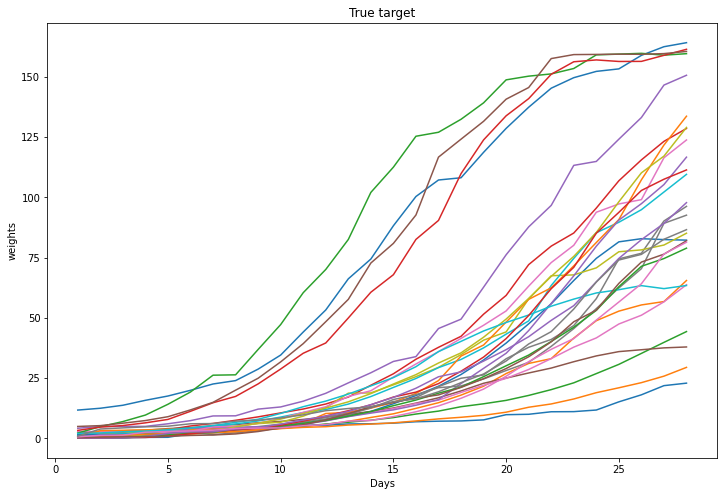

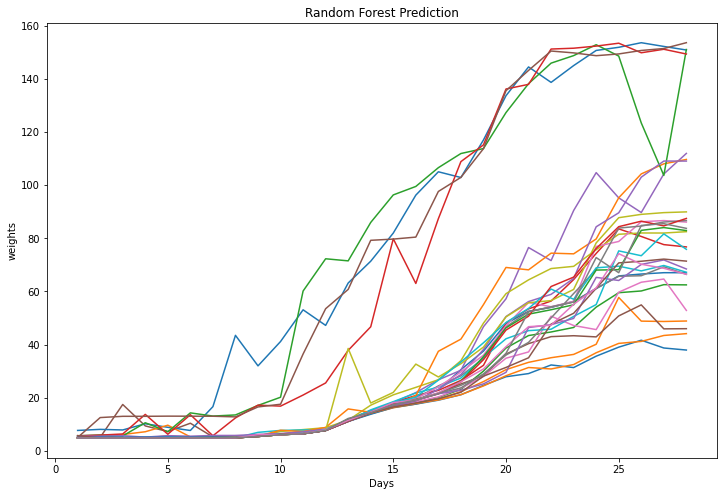

In [139]:
from tensorflow.python.framework.ops import convert_to_tensor
plt.figure(figsize=(12,8))
for i in range(28):
  plt.plot(np.arange(1,29).reshape(-1,1),df_train_target[i*28:(i+1)*28])
plt.title('True target')
plt.xlabel('Days')
plt.ylabel('weights')
plt.show()
predictions = best_rf.predict(Convert_for_tradition(std_inputs))
plt.figure(figsize=(12,8))
for i in range(28):
  plt.plot(np.arange(1,29).reshape(-1,1),predictions[i*28:(i+1)*28])
plt.title('Random Forest Prediction')
plt.ylabel('weights')
plt.xlabel('Days')

plt.show()

In [167]:
index=[best_rf.feature_importances_>np.percentile(best_rf.feature_importances_,90)]

In [164]:
len(best_rf.feature_importances_>np.percentile(best_rf.feature_importances_,90))

360

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
<ipython-input-169-1450e45efff2>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(Convert_for_tradition(std_inputs).columns[index],best_rf.feature_importances_[index])


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45572 missing from current font.
  font.set_

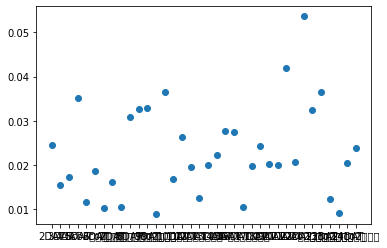

In [169]:
plt.scatter(Convert_for_tradition(std_inputs).columns[index]==True,best_rf.feature_importances_[index])

In [6]:
dense_first=20
dense_second=10
inputs = []
for i in range(24):
  inputs.append(keras.layers.Input(shape=[15],name='time'+str(i)))
hiddens=[]
for i in range(24):
  if i ==0 :
    hiddens.append(keras.layers.Dense(dense_first,activation='relu')(inputs[i]))
    hiddens.append(keras.layers.BatchNormalization()(hiddens[-1]))
    hiddens.append(keras.layers.Dense(dense_second,activation='relu')(hiddens[-1]))
    hiddens.append(keras.layers.BatchNormalization()(hiddens[-1]))
  else:
    hiddens.append(keras.layers.concatenate([inputs[i],hiddens[-1]]))
    hiddens.append(keras.layers.BatchNormalization()(hiddens[-1]))
    hiddens.append(keras.layers.Dense(dense_first,activation='relu')(hiddens[-1]))
    hiddens.append(keras.layers.BatchNormalization()(hiddens[-1]))
    hiddens.append(keras.layers.Dense(dense_second,activation='relu')(hiddens[-1]))
    hiddens.append(keras.layers.BatchNormalization()(hiddens[-1]))
output=keras.layers.Dense(1)(hiddens[-1])
model = keras.Model(inputs=inputs,outputs=[output])
model.compile(loss='mae',optimizer=keras.optimizers.SGD(lr=1e-3))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time0 (InputLayer)             [(None, 15)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 20)           320         ['time0[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 20)          80          ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dense_1 (Dense)                (None, 10)           210         ['batch_normalization[0][0]']

In [32]:
from scipy.optimize.minpack import shape
def TensorProcessing(data):
  tensor=[]
  for aday in data:
    array=[]
    for hour in range(24):
      array.append(aday[hour])
    tensor.append(array)
  return tf.convert_to_tensor(tensor)
tensor_data = TensorProcessing(data)

In [40]:
model.fit(data_list,target)

ValueError: ignored

In [33]:
tensor_data.shape

TensorShape([700, 24, 15])

In [36]:
data_list = []
for i in range(24):
  data_list.append(tensor_data[:,i,:])

In [38]:
tf.convert_to_tensor(data_list).shape

TensorShape([24, 700, 15])